# import

In [310]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import sounddevice as sd
from scipy.io.wavfile import write as wav_write
import os

%matplotlib inline

try:
    from midiutil import MIDIFile
    midiutil_available = True
    print("MIDIUtil library found.")
except ImportError:
    midiutil_available = False
    print("MIDIUtil library not found.")

sd.default.samplerate = 44100
sd.default.channels = 1
current_dir = os.getcwd() # Get current working directory
print(f"Working directory: {current_dir}")
print(sd.query_devices())
sd.default.device = (None, 1)

MIDIUtil library found.
Working directory: /Users/ziqin
> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)
  2 ZoomAudioDevice, Core Audio (2 in, 2 out)


# HAT-P-7 b

multiple transits from different quarters of the same planet, you can hear subtle differences. 

Searching for HAT-P-7 b data...
Processed light curve from 3 quarter(s), length: 12866
Identified transit center times for sonification: [352.86459999999994, 419.00559999999996, 485.1465999999999, 551.2875999999999, 617.4285999999998]


/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/2499618298.py:22: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed_long = stitched_lc.PDCSAP_FLUX.normalize().flatten(window_length=801).remove_outliers(sigma=5)


<Figure size 1500x500 with 0 Axes>

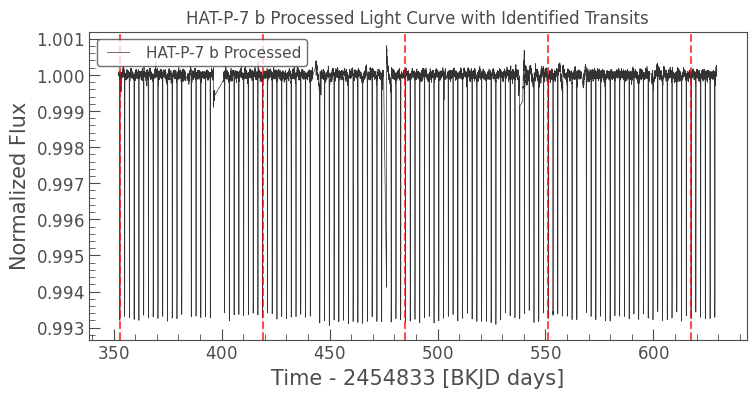

In [311]:
# --- Data Preparation: Load a longer segment of data ---
print("Searching for HAT-P-7 b data...")
search_q4 = lk.search_lightcurve("HAT-P-7 b", author="Kepler", cadence="long", quarter=4)
search_q5 = lk.search_lightcurve("HAT-P-7 b", author="Kepler", cadence="long", quarter=5)
search_q6 = lk.search_lightcurve("HAT-P-7 b", author="Kepler", cadence="long", quarter=6)

lc_collection_list = []
if search_q4: lc_collection_list.append(search_q4.download(quality_bitmask='default'))
if search_q5: lc_collection_list.append(search_q5.download(quality_bitmask='default'))
if search_q6: lc_collection_list.append(search_q6.download(quality_bitmask='default'))

# Filter out None results if a download failed
lc_collection_list = [lc for lc in lc_collection_list if lc is not None]
lc_processed_long = None
transit_times_to_sonify = [] # Initialize correctly

if lc_collection_list:
    lc_collection = lk.LightCurveCollection(lc_collection_list)
    stitched_lc = lc_collection.stitch().remove_nans()
    if stitched_lc and len(stitched_lc) > 0:
        # Further processing
        lc_processed_long = stitched_lc.PDCSAP_FLUX.normalize().flatten(window_length=801).remove_outliers(sigma=5)
        print(f"Processed light curve from {len(lc_collection_list)} quarter(s), length: {len(lc_processed_long)}")

        # Known parameters for HAT-P-7 b
        period_hatp7b = 2.2047  # days
        epoch_bkjd_hatp7b = 906.24 # BKJD (original epoch)

        transit_duration_approx_days = 0.17 # Approximate duration of transit

        min_time = lc_processed_long.time.value.min()
        max_time = lc_processed_long.time.value.max()

        # Start with a known transit and step forward/backward to find ones in view
        current_transit_time = 401.368 # Known transit in Q4
        
        # Adjust to be near the start of the data range
        while current_transit_time > min_time + period_hatp7b: # Go backwards first
            current_transit_time -= period_hatp7b
        while current_transit_time < min_time - period_hatp7b/2: # Ensure it's within or just before range
             current_transit_time += period_hatp7b
        # If it's still before min_time, advance one period
        if current_transit_time < min_time:
            current_transit_time += period_hatp7b
            
        num_transits_to_find = 5
        while len(transit_times_to_sonify) < num_transits_to_find and current_transit_time < max_time + period_hatp7b/2:
            # Add if the transit center is within the data range
            if current_transit_time >= min_time - period_hatp7b/2 and current_transit_time <= max_time + period_hatp7b/2:
                transit_times_to_sonify.append(current_transit_time)
            current_transit_time += 30*period_hatp7b

        print(f"Identified transit center times for sonification: {transit_times_to_sonify}")

        if transit_times_to_sonify:
            plt.figure(figsize=(15, 5))
            lc_processed_long.plot(label="HAT-P-7 b Processed")
            for tt in transit_times_to_sonify:
                plt.axvline(tt, color='red', linestyle='--', alpha=0.7)
            plt.title("HAT-P-7 b Processed Light Curve with Identified Transits")
            plt.show()
        else:
            print("No transits identified within the data range.")
    else:
        print("Stitched light curve is empty after processing.")

In [312]:
def sonify_segment(flux_segment, sample_rate=44100, note_duration_sec=0.1,
                   min_freq=220, max_freq=660, min_amp=0.3, max_amp=0.6,
                   use_inverse_pitch=False):
    """Sonifies a flux segment by mapping flux to pitch and amplitude."""
    if not isinstance(flux_segment, np.ndarray) or len(flux_segment) == 0:
        print("Warning: sonify_segment received empty or invalid flux_segment.")
        return np.array([])

    data_min_flux = np.min(flux_segment)
    data_max_flux = np.max(flux_segment)
    
    # Handle case where all flux values are the same
    if data_min_flux == data_max_flux:
        data_max_flux += 1e-9 # Add a tiny offset to avoid division by zero in interp
        if data_max_flux == 0 : data_max_flux = 1e-9 # if original was 0

    # Frequencies
    if use_inverse_pitch: # Lower flux = higher pitch
        frequencies = np.interp(flux_segment, (data_min_flux, data_max_flux), (max_freq, min_freq))
    else: # Lower flux = lower pitch
        frequencies = np.interp(flux_segment, (data_min_flux, data_max_flux), (min_freq, max_freq))

    # Amplitudes
    amplitudes = np.interp(flux_segment, (data_min_flux, data_max_flux), (min_amp, max_amp))

    total_samples_per_note = int(sample_rate * note_duration_sec)
    t_note = np.linspace(0, note_duration_sec, total_samples_per_note, endpoint=False)
    
    # Using a list to append notes and then concatenating once is more efficient
    notes_list = []

    for i in range(len(flux_segment)):
        freq = frequencies[i]
        amp = amplitudes[i]
        current_note_wave = amp * np.sin(2 * np.pi * freq * t_note)
        
        # Simple fade envelope
        fade_duration_sec = 0.005
        fade_samples = int(sample_rate * fade_duration_sec)
        if total_samples_per_note > 2 * fade_samples: # Ensure note is long enough for fades
            fade_in_curve = np.linspace(0, 1, fade_samples)
            fade_out_curve = np.linspace(1, 0, fade_samples)
            current_note_wave[:fade_samples] *= fade_in_curve
            current_note_wave[-fade_samples:] *= fade_out_curve
            
        notes_list.append(current_note_wave)
    
    if not notes_list:
        return np.array([])
    return np.concatenate(notes_list)

In [313]:
all_transits_audio_list = []
segment_duration_for_sonification = transit_duration_approx_days * 1.5 if 'transit_duration_approx_days' in locals() else 0.16 * 1.5
using_real_data_ex1 = (lc_processed_long is not None and len(transit_times_to_sonify) > 0 and not isinstance(transit_times_to_sonify[0], str))

if using_real_data_ex1:
    for i, transit_time in enumerate(transit_times_to_sonify):
        print(f"Processing transit {i+1} centered at {transit_time:.2f} BKJD")
        
        # Extract segment around this transit
        time_mask_segment = (lc_processed_long.time.value > transit_time - segment_duration_for_sonification / 2) & \
                            (lc_processed_long.time.value < transit_time + segment_duration_for_sonification / 2)
        current_segment_lc = lc_processed_long[time_mask_segment]

        if current_segment_lc and len(current_segment_lc.flux) > 0:
            flux_to_sonify = current_segment_lc.flux.value
            
            sonified_segment = sonify_segment(flux_to_sonify,
                                              note_duration_sec=0.1,
                                              min_freq=200, max_freq=600,
                                              min_amp=0.2, max_amp=0.5)
            #print(f"  Segment {i+1}: audio length = {len(sonified_segment)}")
            if len(sonified_segment) > 0:
                 all_transits_audio_list.append(sonified_segment)

            # Add a short silence or a separator sound between transits
            if i < len(transit_times_to_sonify) - 1 and len(sonified_segment) > 0:
                silence_duration_sec = 0.5
                silence = np.zeros(int(sd.default.samplerate * silence_duration_sec))
                all_transits_audio_list.append(silence)
        else:
            print(f"  No data in segment for transit at {transit_time:.2f}")
            
# Concatenate all parts
if all_transits_audio_list:
    all_transits_audio = np.concatenate(all_transits_audio_list)
else:
    all_transits_audio = np.array([])

# Normalize final audio and play
if len(all_transits_audio) > 0:
    # Check for NaNs or Infs before normalization
    if not np.all(np.isfinite(all_transits_audio)):
        print("Warning: Non-finite values detected in audio signal. Attempting to clean...")
        all_transits_audio = np.nan_to_num(all_transits_audio) # Convert NaNs to 0, Infs to large numbers
    
    max_abs_val = np.max(np.abs(all_transits_audio))
    if max_abs_val == 0: # Avoid division by zero if signal is all zeros
        print("Warning: Audio signal is all zeros. Cannot normalize.")
        all_transits_audio_norm = all_transits_audio
    else:
        all_transits_audio_norm = all_transits_audio / max_abs_val * 0.8
        
    print("\nPlaying sonification of multiple transits...")
    sd.default.samplerate = 44100 
    
    sd.play(all_transits_audio_norm, sd.default.samplerate)
    sd.wait()
    print("Playback complete.")
    
    wav_filename_multi = os.path.join(current_dir, "sonified_multiple_transits.wav")
try:
    if hasattr(all_transits_audio_norm, 'filled'):
        audio_data = all_transits_audio_norm.filled(0)
    else:
        audio_data = all_transits_audio_norm

    audio_data = np.array(audio_data, dtype=np.float64)


    audio_int16 = (audio_data * 32767).astype(np.int16)

    wav_write(wav_filename_multi, sd.default.samplerate, audio_int16)
    print(f"Multi-transit audio saved as {wav_filename_multi}")

except Exception as e:
    print(f"Error saving multi-transit WAV: {e}")
else:
    print("No audio generated for multiple transits.")





Processing transit 1 centered at 352.86 BKJD
Processing transit 2 centered at 419.01 BKJD
Processing transit 3 centered at 485.15 BKJD
Processing transit 4 centered at 551.29 BKJD
Processing transit 5 centered at 617.43 BKJD

Playing sonification of multiple transits...
Playback complete.
Multi-transit audio saved as /Users/ziqin/sonified_multiple_transits.wav
No audio generated for multiple transits.


# 2 planets from KOI-94 system


Processing KOI-94 Q1 data...
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
------------------ -------------- ... -------------- --------------
154.84823724954185  9.9993980e-01 ...  5.6950543e-03  1.8299861e-02
154.86867179611727  9.9995118e-01 ...  6.1776889e-03  1.7908322e-02
154.88910624268465  9.9990183e-01 ...  5.8853696e-03  1.8186683e-02
154.90954068902647  9.9982690e-01 ...  5.5673891e-03  1.8363390e-02
 154.9299751353683  9.9980449e-01 ...  5.8246842e-03  1.8516807e-02
   154.95040958147  9.9895998e-01 ...  5.8600586e-03  1.8178174e-02
154.97084402734617  9.9576151e-01 ...  5.6211697e-03  1.8302506e-02
154.99127847322234  9.9506424e-01 ...  5.6178980e-03  1.8112365e-02
155.01171281885763  9.9469224e-01 ...  6.0466244e-03  1.8295269e-02
               ...            ... ...            ...            ...
 155.1138851449723  9.9440424e-01 ...  6.9775502e-03  1.7740825e-02
155.13431948967627 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/4185682570.py:7: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401)


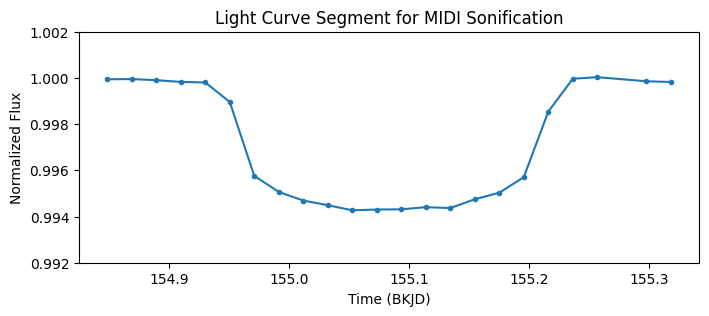

In [314]:
search_result_kepler_q1 = lk.search_lightcurve("KOI-94", author="Kepler", cadence="long", quarter = 1)
lc_transit_segment = None # Initialize
print("Processing KOI-94 Q1 data...")
# Download the first item from search result by default if not specifying index
lcf_kepler = search_result_kepler_q1.download(quality_bitmask='default') 

lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401)

transit_center_time_bkjd = 155.08
transit_duration_days = 0.5
time_mask = (lc_processed.time.value > transit_center_time_bkjd - transit_duration_days / 2) & \
            (lc_processed.time.value < transit_center_time_bkjd + transit_duration_days / 2)

lc_transit_segment = lc_processed[time_mask]
print(lc_transit_segment)

print(len(lc_transit_segment.flux))

if lc_transit_segment and len(lc_transit_segment.flux) > 0:
    flux_datab = lc_transit_segment.flux.value
    lc_planet_A_flux = flux_datab
    time_datab = lc_transit_segment.time.value # These are in BKJD
    print(f"Using {len(flux_datab)} data points for MIDI sonification.")
    # Plot for confirmation
    plt.figure(figsize=(8, 3))
    plt.plot(time_datab, flux_datab, '.-')
    plt.title("Light Curve Segment for MIDI Sonification")
    plt.xlabel("Time (BKJD)")
    plt.ylabel("Normalized Flux")
    plt.ylim(0.992, 1.002)
    plt.show()

Processing KOI-94 Q1 data...
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
------------------ -------------- ... -------------- --------------
158.66947573943617  1.0000435e+00 ...  1.3368821e-02  2.6435427e-02
158.68991005713906  1.0001808e+00 ...  1.3115581e-02  2.6310179e-02
158.71034447483544  1.0001022e+00 ...  1.3622955e-02  2.6194841e-02
 158.7307787923055  1.0001464e+00 ...  1.3460954e-02  2.6621040e-02
158.75121330954426  9.9980050e-01 ...  1.3345487e-02  2.6754070e-02
158.77164772678225  9.9949023e-01 ...  1.3068778e-02  2.6671655e-02
 158.7920821435473  9.9939990e-01 ...  1.3355851e-02  2.6532186e-02
158.81251656031964  9.9928382e-01 ...  1.3535773e-02  2.6542677e-02
 158.8329509770847  9.9961532e-01 ...  1.3640090e-02  2.6536359e-02
158.85338539339136  9.9933497e-01 ...  1.3602885e-02  2.7116854e-02
158.87381970969727  9.9935247e-01 ...  1.3550623e-02  2.7137259e-02
 158.8942542260047 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/1923706721.py:7: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed_2 = lcf_kepler_2.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401)


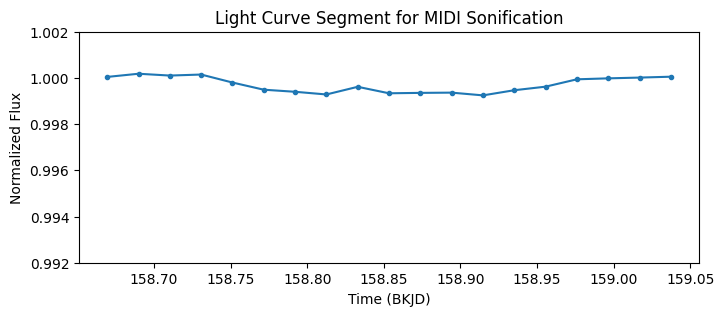

In [315]:
search_result_kepler_q1_2 = lk.search_lightcurve("KOI-94", author="Kepler", cadence="long", quarter = 1)
lc_transit_segment_2 = None # Initialize
print("Processing KOI-94 Q1 data...")
# Download the first item from search result by default if not specifying index
lcf_kepler_2 = search_result_kepler_q1_2.download(quality_bitmask='default') 

lc_processed_2 = lcf_kepler_2.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401)

transit_center_time_bkjd_2 = 158.85 
transit_duration_days_2 = 0.4
time_mask_2 = (lc_processed_2.time.value > transit_center_time_bkjd_2 - transit_duration_days_2 / 2) & \
            (lc_processed_2.time.value < transit_center_time_bkjd_2 + transit_duration_days_2 / 2)

lc_transit_segment_2 = lc_processed_2[time_mask_2]
print(lc_transit_segment_2)

print(len(lc_transit_segment_2.flux))

if lc_transit_segment_2 and len(lc_transit_segment_2.flux) > 0:
    flux_datac = lc_transit_segment_2.flux.value
    lc_planet_B_flux = flux_datac
    time_datac = lc_transit_segment_2.time.value # These are in BKJD
    print(f"Using {len(flux_datac)} data points for MIDI sonification.")
    # Plot for confirmation
    plt.figure(figsize=(8, 3))
    plt.plot(time_datac, flux_datac, '.-')
    plt.title("Light Curve Segment for MIDI Sonification")
    plt.xlabel("Time (BKJD)")
    plt.ylabel("Normalized Flux")
    plt.ylim(0.992, 1.002)
    plt.show()

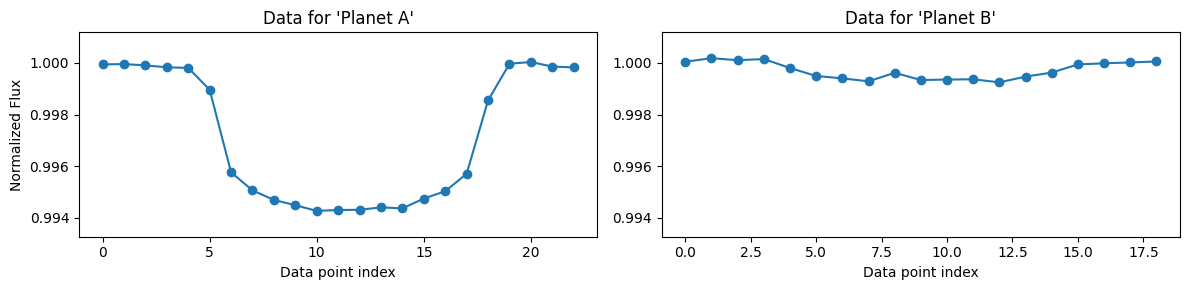

In [316]:
# Data for "Planet A" and "Planet B"

segment_duration_comp = segment_duration_for_sonification 

plt.figure(figsize=(12, 3))
y_min_plot = min(np.min(lc_planet_A_flux) if len(lc_planet_A_flux)>0 else 1.0, np.min(lc_planet_B_flux) if len(lc_planet_B_flux)>0 else 1.0) - 0.001
y_max_plot = max(np.max(lc_planet_A_flux) if len(lc_planet_A_flux)>0 else 1.0, np.max(lc_planet_B_flux) if len(lc_planet_B_flux)>0 else 1.0) + 0.001
if y_min_plot >= y_max_plot : y_max_plot = y_min_plot + 0.002 # Ensure valid range

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(lc_planet_A_flux)), lc_planet_A_flux, 'o-')
plt.title("Data for 'Planet A'")
plt.ylabel("Normalized Flux")
plt.xlabel("Data point index")
if len(lc_planet_A_flux) > 0 : plt.ylim(y_min_plot, y_max_plot)

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(lc_planet_B_flux)), lc_planet_B_flux, 'o-')
plt.title("Data for 'Planet B'")
plt.xlabel("Data point index")
if len(lc_planet_B_flux) > 0 : plt.ylim(y_min_plot, y_max_plot)
plt.tight_layout()
plt.show()

In [317]:
# Sonify Planet A (e.g., lower, slightly longer notes)
audio_planet_A = np.array([])
if len(lc_planet_A_flux) > 0:
    audio_planet_A = sonify_segment(lc_planet_A_flux,
                                  note_duration_sec=0.12,
                                  min_freq=150, max_freq=450, # Lower range
                                  min_amp=0.2, max_amp=0.5)

# Sonify Planet B (e.g., higher, shorter notes)
audio_planet_B = np.array([])
if len(lc_planet_B_flux) > 0:
    audio_planet_B = sonify_segment(lc_planet_B_flux,
                                  note_duration_sec=0.08,
                                  min_freq=300, max_freq=900, # Higher range
                                  min_amp=0.2, max_amp=0.5)

# Concatenate with a separator
separator_sound_samples = int(sd.default.samplerate * 0.2) # 0.2 sec
t_sep = np.linspace(0, 0.2, separator_sound_samples, endpoint=False)
separator_wave = 0.3 * np.sin(2 * np.pi * 1000 * t_sep) # 1000 Hz tone
fade_samples_sep = int(sd.default.samplerate * 0.01)
if len(separator_wave) > 2 * fade_samples_sep:
    separator_wave[:fade_samples_sep] *= np.linspace(0,1,fade_samples_sep)
    separator_wave[-fade_samples_sep:] *= np.linspace(1,0,fade_samples_sep)

comparative_audio_list_np = []
if len(audio_planet_A) > 0: comparative_audio_list_np.append(audio_planet_A)
if len(audio_planet_A) > 0 and len(audio_planet_B) > 0 : comparative_audio_list_np.append(separator_wave)
if len(audio_planet_B) > 0: comparative_audio_list_np.append(audio_planet_B)

comparative_audio_numpy = np.concatenate(comparative_audio_list_np) if comparative_audio_list_np else np.array([])

if len(comparative_audio_numpy) > 0:
    if not np.all(np.isfinite(comparative_audio_numpy)): comparative_audio_numpy = np.nan_to_num(comparative_audio_numpy)
    max_abs_val_comp = np.max(np.abs(comparative_audio_numpy))
    if max_abs_val_comp == 0: comparative_audio_numpy_norm = comparative_audio_numpy
    else: comparative_audio_numpy_norm = comparative_audio_numpy / max_abs_val_comp * 0.8
        
    print("Playing comparative sonification (NumPy - different freq ranges)...")
    sd.play(comparative_audio_numpy_norm, sd.default.samplerate)
    sd.wait()
    print("Playback complete.")
    wav_filename_comp_np = os.path.join(current_dir, "sonified_comparative_numpy.wav")
    try:
        audio_array = np.array(comparative_audio_numpy_norm.filled(0))
        # Scale to 16-bit integer range if saving as standard WAV
        audio_to_save = np.int16(audio_array * 32767)
        wav_write(wav_filename_comp_np, sd.default.samplerate, np.int16(audio_array * 32767))
        print(f"Comparative audio (NumPy) saved as {wav_filename_comp_np}")
    except Exception as e:
        print(f"Error saving comparative WAV (NumPy): {e}")
else:
    print("No audio generated for NumPy comparative sonification.")

Playing comparative sonification (NumPy - different freq ranges)...
Playback complete.
Comparative audio (NumPy) saved as /Users/ziqin/sonified_comparative_numpy.wav


In [318]:
if midiutil_available and len(lc_planet_A_flux) > 0 and len(lc_planet_B_flux) > 0:
    midi_obj_comp = MIDIFile(2) # Two tracks for two "planets"
    tempo_bpm = 120
    # Set tempo for all tracks (MIDIFile applies it globally or per track if specified multiple times)
    midi_obj_comp.addTempo(0, 0, tempo_bpm) 
    # If using multiple tracks and wanting them to be perfectly aligned, often one tempo event at time 0 is enough.
    # midi_obj_comp.addTempo(1, 0, tempo_bpm) # Technically not needed if tempo is for the whole piece

    # --- Planet A Sonification (Track 0, e.g., Piano) ---
    track_A = 0
    channel_A = 0 # MIDI channels 0-15 (often 1-16 in DAWs)
    instrument_A = 0  # 0 = Acoustic Grand Piano in General MIDI
    midi_obj_comp.addProgramChange(track_A, channel_A, 0, instrument_A) # Time = 0 for program change

    min_flux_A = np.min(lc_planet_A_flux)
    max_flux_A = np.max(lc_planet_A_flux)
    if min_flux_A == max_flux_A: max_flux_A += 1e-9
        
    notes_A = np.interp(lc_planet_A_flux, (min_flux_A, max_flux_A), (50, 70)).astype(int) # Lower pitch range
    velocities_A = np.interp(lc_planet_A_flux, (min_flux_A, max_flux_A), (50, 100)).astype(int)
    
    time_offset_beats = 0.0 # Start Planet A at time 0
    note_duration_beats_midi = 0.4
    time_step_beats = 0.5 # Spacing between notes (onset to onset)

    for i in range(len(lc_planet_A_flux)):
        midi_obj_comp.addNote(track_A, channel_A, notes_A[i], time_offset_beats + i * time_step_beats, note_duration_beats_midi, velocities_A[i])

    # --- Planet B Sonification (Track 1, e.g., Flute, starts after Planet A) ---
    track_B = 1 # Use a different track for clarity and independent instrument control
    channel_B = 1 # Using a different channel is good practice for different instruments
    instrument_B = 73 # 73 = Flute in General MIDI
    # Program change for track_B should also be at its own time 0 for that track's events, 
    # or at the time the first note on that track will play if you want it to change mid-sequence.
    # For sequential playback, place the program change just before its notes start.
    start_time_planet_B_beats = time_offset_beats + len(lc_planet_A_flux) * time_step_beats + 2.0 # 2 beats gap
    midi_obj_comp.addProgramChange(track_B, channel_B, start_time_planet_B_beats, instrument_B) 

    min_flux_B = np.min(lc_planet_B_flux)
    max_flux_B = np.max(lc_planet_B_flux)
    if min_flux_B == max_flux_B: max_flux_B += 1e-9
        
    notes_B = np.interp(lc_planet_B_flux, (min_flux_B, max_flux_B), (65, 85)).astype(int) # Higher pitch range
    velocities_B = np.interp(lc_planet_B_flux, (min_flux_B, max_flux_B), (60, 110)).astype(int)

    for i in range(len(lc_planet_B_flux)):
        midi_obj_comp.addNote(track_B, channel_B, notes_B[i], start_time_planet_B_beats + i * time_step_beats, note_duration_beats_midi, velocities_B[i])

    output_midi_comp_file = os.path.join(current_dir, "sonified_comparative.mid")
    try:
        with open(output_midi_comp_file, "wb") as f:
            midi_obj_comp.writeFile(f)
        print(f"Comparative MIDI file saved as: {output_midi_comp_file}")
        print("Play this with a MIDI player. You should hear Piano then Flute.")
    except Exception as e:
        print(f"Error writing comparative MIDI file: {e}")
else:
    if not midiutil_available: print("MIDIUtil not available, skipping comparative MIDI example.")
    else: print("Not enough data for comparative MIDI example (Planet A or B flux empty).")

Comparative MIDI file saved as: /Users/ziqin/sonified_comparative.mid
Play this with a MIDI player. You should hear Piano then Flute.


# comparing Kepler-10 b and HAT-P-7 b

Processing HAT-P-7 Q4 data...
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
------------------ -------------- ... -------------- --------------
401.23309159249766  9.9999177e-01 ... -1.2381945e-02 -1.0605725e-02
 401.2535250900546  1.0001127e+00 ... -1.2512537e-02 -1.0735904e-02
401.27395878795505  9.9986452e-01 ... -1.2647740e-02 -1.0937720e-02
401.29439238621126  9.9555908e-01 ... -1.2497589e-02 -1.0654209e-02
  401.314825984693  9.9412501e-01 ... -1.2612767e-02 -1.0786489e-02
 401.3352595834149  9.9357744e-01 ... -1.2644582e-02 -1.0660779e-02
  401.355693182486  9.9340739e-01 ... -1.2662202e-02 -1.0983602e-02
401.37612678166624  9.9349859e-01 ... -1.2716637e-02 -1.0654183e-02
 401.3965604813202  9.9376896e-01 ... -1.2606842e-02 -1.0523413e-02
401.41699398108904  9.9440256e-01 ... -1.2661232e-02 -1.1061116e-02
  401.437427581317  9.9845919e-01 ... -1.2797548e-02 -1.0771235e-02
401.45786128166947

/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/4068312233.py:8: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401).remove_outliers(sigma=5)


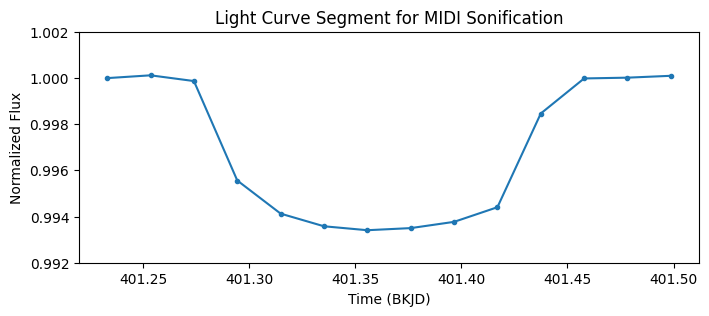

[0.99999177 1.00011265 0.99986452 0.99555908 0.99412501 0.99357744
 0.99340739 0.99349859 0.99376896 0.99440256 0.99845919 0.99997759
 1.00001121 1.00009191]


In [319]:
search_result_kepler_q4 = lk.search_lightcurve("HAT-P-7", author="Kepler", cadence="long", quarter = 4)
#lc_planet_A_flux = None
lc_transit_segment = None # Initialize
print("Processing HAT-P-7 Q4 data...")
# Download the first item from search result by default if not specifying index
lcf_kepler = search_result_kepler_q4.download(quality_bitmask='default') 

lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401).remove_outliers(sigma=5)

transit_center_time_bkjd = 401.368
transit_duration_days = 0.3
time_mask = (lc_processed.time.value > transit_center_time_bkjd - transit_duration_days / 2) & \
            (lc_processed.time.value < transit_center_time_bkjd + transit_duration_days / 2)

lc_transit_segment = lc_processed[time_mask]
print(lc_transit_segment)

print(len(lc_transit_segment.flux))

if lc_transit_segment and len(lc_transit_segment.flux) > 0:
    flux_data1 = lc_transit_segment.flux.value
    lc_planet_A_flux = flux_data1
    print("✅ Manually assigned lc_planet_A_flux")
    print(lc_planet_A_flux)
    print(f"Length: {len(lc_planet_A_flux)}")
    time_data1 = lc_transit_segment.time.value # These are in BKJD
    print(f"Using {len(flux_data1)} data points for MIDI sonification.")
    # Plot for confirmation
    plt.figure(figsize=(8, 3))
    plt.plot(time_data1, flux_data1, '.-')
    plt.title("Light Curve Segment for MIDI Sonification")
    plt.xlabel("Time (BKJD)")
    plt.ylabel("Normalized Flux")
    plt.ylim(0.992, 1.002)
    plt.show()

print(lc_planet_A_flux)

Processing Kepler-10 Q1 data...
       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
------------------ -------------- ... -------------- --------------
142.36286029664188  9.9997485e-01 ...  1.1521865e-03  1.6466077e-02
  142.383294348685  9.9999988e-01 ...  1.0590970e-03  1.6063239e-02
 142.4037285007289  9.9999940e-01 ...  1.2261474e-03  1.6303066e-02
142.42416275253345  1.0000066e+00 ...  1.2464157e-03  1.5734494e-02
142.44459680434375  9.9980391e-01 ...  1.1193980e-03  1.6282422e-02
 142.4650309560384  9.9979807e-01 ...  1.1718695e-03  1.5595251e-02
142.48546500773227  9.9975551e-01 ...  1.2208410e-03  1.6068717e-02
142.50589925918757  9.9986536e-01 ...  1.2132857e-03  1.5601862e-02
142.52633341064939  1.0000105e+00 ...  1.2203885e-03  1.5878558e-02
 142.5467675618711  1.0000099e+00 ...  1.1909797e-03  1.5560337e-02
10
Using 10 data points for MIDI sonification.


/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/10009472.py:8: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed2 = lcf_kepler2.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401).remove_outliers(sigma=5)


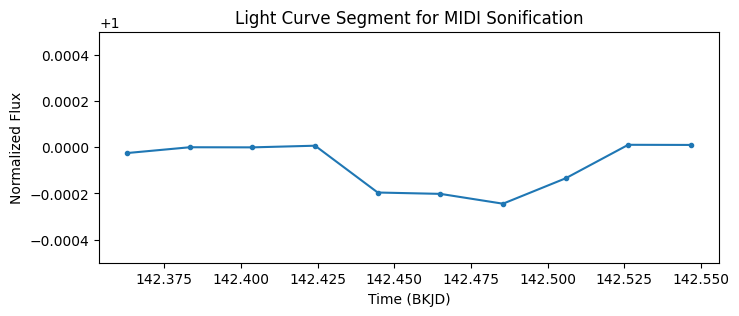

In [320]:
search_result_kepler_q1 = lk.search_lightcurve("Kepler-10", author="Kepler", cadence="long", quarter = 1)
#lc_planet_B_flux = None
lc_transit_segment2 = None # Initialize
print("Processing Kepler-10 Q1 data...")
# Download the first item from search result by default if not specifying index
lcf_kepler2 = search_result_kepler_q1.download(quality_bitmask='default') 

lc_processed2 = lcf_kepler2.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=401).remove_outliers(sigma=5)

transit_center_time_bkjd2 = 142.4625
transit_duration_days2 = 0.2
time_mask2 = (lc_processed2.time.value > transit_center_time_bkjd2 - transit_duration_days2 / 2) & \
            (lc_processed2.time.value < transit_center_time_bkjd2 + transit_duration_days2 / 2)

lc_transit_segment2 = lc_processed2[time_mask2]
print(lc_transit_segment2)

print(len(lc_transit_segment2.flux))

if lc_transit_segment2 and len(lc_transit_segment2.flux) > 0:
    flux_data2 = lc_transit_segment2.flux.value
    lc_planet_B_flux = flux_data2
    time_data2 = lc_transit_segment2.time.value # These are in BKJD
    print(f"Using {len(flux_data2)} data points for MIDI sonification.")
    # Plot for confirmation
    plt.figure(figsize=(8, 3))
    plt.plot(time_data2, flux_data2, '.-')
    plt.title("Light Curve Segment for MIDI Sonification")
    plt.xlabel("Time (BKJD)")
    plt.ylabel("Normalized Flux")
    plt.ylim(0.9995, 1.0005)
    plt.show()

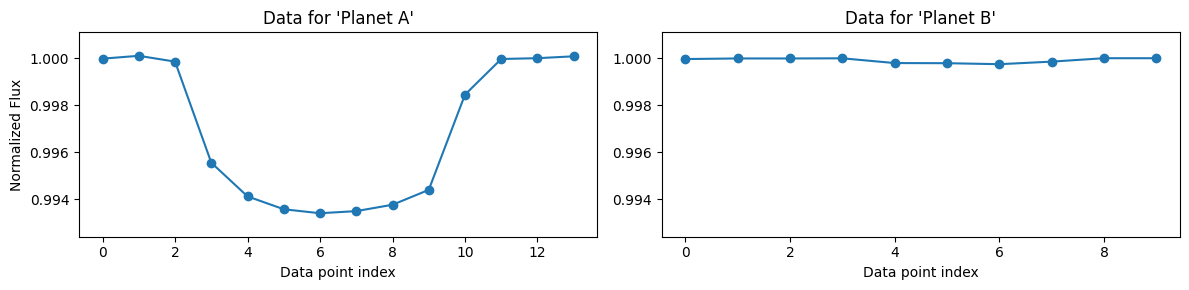

0.9997555103016101


In [321]:
# Data for "Planet A" and "Planet B"


segment_duration_comp = segment_duration_for_sonification

plt.figure(figsize=(12, 3))
y_min_plot = min(np.min(lc_planet_A_flux) if len(lc_planet_A_flux)>0 else 1.0, np.min(lc_planet_B_flux) if len(lc_planet_B_flux)>0 else 1.0) - 0.001
y_max_plot = max(np.max(lc_planet_A_flux) if len(lc_planet_A_flux)>0 else 1.0, np.max(lc_planet_B_flux) if len(lc_planet_B_flux)>0 else 1.0) + 0.001
if y_min_plot >= y_max_plot : y_max_plot = y_min_plot + 0.002 # Ensure valid range

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(lc_planet_A_flux)), lc_planet_A_flux, 'o-')
plt.title("Data for 'Planet A'")
plt.ylabel("Normalized Flux")
plt.xlabel("Data point index")
if len(lc_planet_A_flux) > 0 : plt.ylim(y_min_plot, y_max_plot)

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(lc_planet_B_flux)), lc_planet_B_flux, 'o-')
plt.title("Data for 'Planet B'")
plt.xlabel("Data point index")
if len(lc_planet_B_flux) > 0 : plt.ylim(y_min_plot, y_max_plot)
plt.tight_layout()
plt.show()

print(min(lc_planet_B_flux))

In [322]:
# Sonify Planet A
audio_planet_A = np.array([])
if len(lc_planet_A_flux) > 0:
    audio_planet_A = sonify_segment(lc_planet_A_flux,
                                  note_duration_sec=0.12,
                                  min_freq=150, max_freq=450, # Lower range
                                  min_amp=0.2, max_amp=0.5)

# Sonify Planet B
audio_planet_B = np.array([])
if len(lc_planet_B_flux) > 0:
    audio_planet_B = sonify_segment(lc_planet_B_flux,
                                  note_duration_sec=0.12,
                                  min_freq=150*3*min(lc_planet_B_flux), max_freq=450, #min freq makes it relative to the min flux
                                  min_amp=0.2, max_amp=0.5)

# Concatenate with a separator
silence = np.zeros(int(sd.default.samplerate * 0.5))

comparative_audio_list_np = []
if len(audio_planet_A) > 0: comparative_audio_list_np.append(audio_planet_A)
if len(audio_planet_A) > 0 and len(audio_planet_B) > 0 : comparative_audio_list_np.append(silence)
if len(audio_planet_B) > 0: comparative_audio_list_np.append(audio_planet_B)

comparative_audio_numpy = np.concatenate(comparative_audio_list_np) if comparative_audio_list_np else np.array([])

if len(comparative_audio_numpy) > 0:
    if not np.all(np.isfinite(comparative_audio_numpy)): comparative_audio_numpy = np.nan_to_num(comparative_audio_numpy)
    max_abs_val_comp = np.max(np.abs(comparative_audio_numpy))
    if max_abs_val_comp == 0: comparative_audio_numpy_norm = comparative_audio_numpy
    else: comparative_audio_numpy_norm = comparative_audio_numpy / max_abs_val_comp * 0.8
        
    print("Playing comparative sonification (NumPy - different freq ranges)...")
    sd.play(comparative_audio_numpy_norm, sd.default.samplerate)
    sd.wait()
    print("Playback complete.")
    wav_filename_comp_np = os.path.join(current_dir, "sonified_comparative_numpy.wav")
    try:
        audio_array = np.array(comparative_audio_numpy_norm.filled(0))
        wav_write(wav_filename_comp_np, sd.default.samplerate, np.int16(audio_array * 32767))
        print(f"Comparative audio (NumPy) saved as {wav_filename_comp_np}")
    except Exception as e:
        print(f"Error saving comparative WAV (NumPy): {e}")
else:
    print("No audio generated for NumPy comparative sonification.")

Playing comparative sonification (NumPy - different freq ranges)...
Playback complete.
Comparative audio (NumPy) saved as /Users/ziqin/sonified_comparative_numpy.wav
